Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


Load Dataset

In [3]:
df = pd.read_csv('generated_dataset.csv')
df.head()


,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202


Binning Target: Leak vs No Leak (Percentile-based)

In [4]:
# percentile = 0.8  # 80th percentile
# threshold = df['CR-corrosion defect'].quantile(percentile)
threshold = 0.25  # threshold for leak detection
df['Leak_Status'] = np.where(df['CR-corrosion defect'] >= threshold, 'Leak', 'No Leak')

df.head()



,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect,Leak_Status
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245,No Leak
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262,No Leak
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305,No Leak
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303,No Leak
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202,No Leak


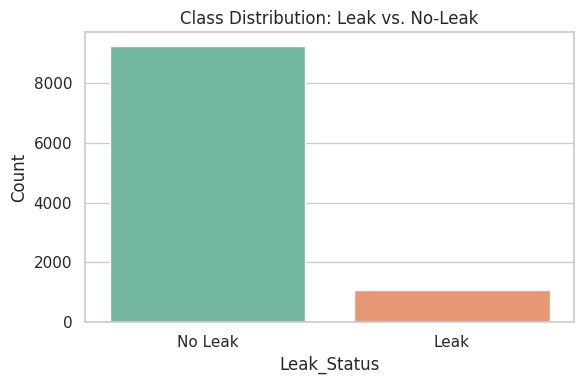

In [5]:

# Visualizing the class distribution

# Assuming your class labels are in the column 'leak_label'
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6,4))

# Countplot of leak classes
sns.countplot(data=df, x='Leak_Status', hue='Leak_Status', palette='Set2', legend=False)

# Optional: Add titles and axis labels
plt.title('Class Distribution: Leak vs. No-Leak')
plt.xlabel('Leak_Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Encode Target Labels

In [5]:
le = LabelEncoder()
y = le.fit_transform(df['Leak_Status'])


Train-Test Split

In [6]:
X = df.drop(['CR-corrosion defect', 'Leak_Status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Train SVM Model

In [7]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train AUC ROC:", roc_auc_score(y_train, y_train_proba[:, 1]))


Train Accuracy: 0.9680553868577675
Train AUC ROC: 0.9775110532459435


Predict & Evaluate

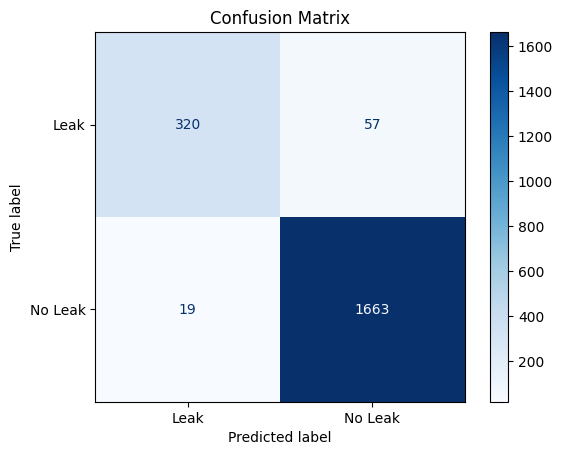

,precision,recall,f1-score,support
Leak,0.943953,0.848806,0.893855,377.000000
No Leak,0.966860,0.988704,0.977660,1682.000000
accuracy,0.963089,0.963089,0.963089,0.963089
macro avg,0.955407,0.918755,0.935757,2059.000000
weighted avg,0.962666,0.963089,0.962316,2059.000000


In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)


Visualize ROC Curves

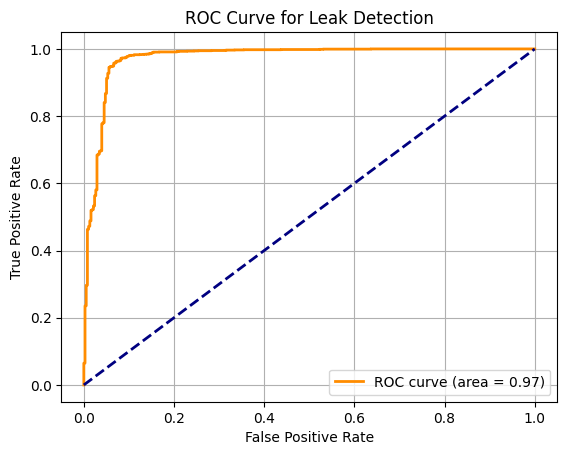

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Leak Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



Visualize Feature Importance

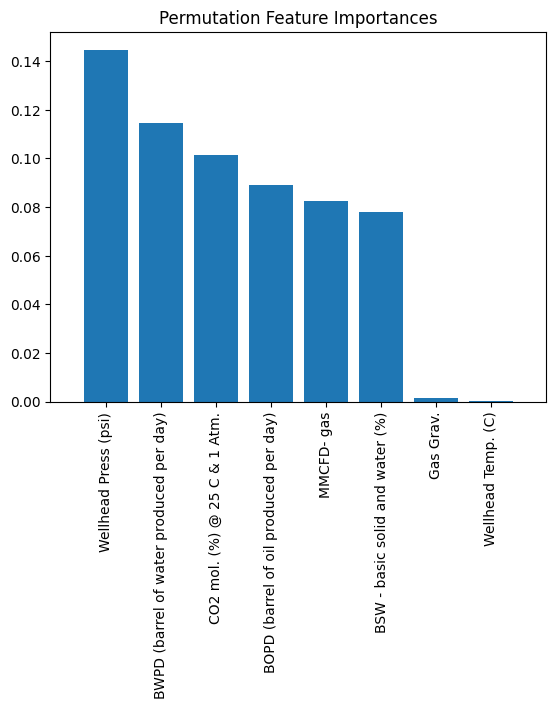

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.title("Permutation Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Save model

In [ ]:
# Save model with pickle
import pickle

with open('svm_leak_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Example usecase

In [ ]:
# Load model with pickle
with open('svm_leak_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Example feature values
example = pd.DataFrame([{
    'Wellhead Temp. (C)': 85,
    'Wellhead Press (psi)': 2500,
    'MMCFD- gas': 12,
    'BOPD (barrel of oil produced per day)': 500,
    'BWPD (barrel of water produced per day)': 200,
    'BSW - basic solid and water (%)': 5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 2.5,
    'Gas Grav.': 0.7
}])

# Use same scaler as during training
example_scaled = scaler.transform(example)

# Predict
pred = model.predict(example_scaled)
pred_label = le.inverse_transform(pred)
print("Predicted Leak Status:", pred_label[0])

# Get probability scores for each class
proba = model.predict_proba(example_scaled)

# Probability for the predicted class:
print(f"Probability: {proba[0][pred[0]] * 100:.2f}%")

Predicted Leak Status: No Leak
Probability: 97.22%
